# Costa Rican Household Poverty Level Prediction


Welcome to another Kaggle challenge! The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. This "data science for good" project offers the opportunity to put our skills towards a task more beneficial to society than getting people to click on ads!

In this notebook, we will walk through a complete machine learning solution: first, get introduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions. __While this notebook may not get us to the top of the leaderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. Kaggle projects can teach us a lot about machine learning, but several of the strategies used to get to the very top of the leaderboard are not best practices, so here we'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects are competitions, I think they are best described as "a machine learning education" disguised as a contest!"

If you are looking to follow-up on this work, I have additional work including a [kernel on using Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/featuretools-for-good) with [Featuretools](https://docs.featuretools.com/#minute-quick-start) for this problem (with slightly higher leaderboard score). (If you enjoy my writing style and explanations, I write for [Towards Data Science](http://medium.com/@williamkoehrsen/))

## Problem and Data Explanation

The data for this competition is provided in two files: `train.csv` and `test.csv`. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents __one individual__ and each column is a __feature, either unique to the individual, or for the household of the individual__. The training set has one additional column, `Target`, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty. 

This is a __supervised multi-class classification machine learning problem__:

* __Supervised__: provided with the labels for the training data
* __Multi-class classification__: Labels are discrete values with 4 classes

### Objective

The objective is to predict poverty on a __household level__. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some _aggregations of the individual data_ for each household. Moreover, we have to make a prediction for every individual in the test set, but _"ONLY the heads of household are used in scoring"_ which means we want to predict poverty on a household basis. 

__Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where `parentesco1 == 1.0`.__ We will cover how to correct this in the notebook (for more info take a look at the [competition main discussion](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403)).

The `Target` values represent poverty levels as follows:

    1 = extreme poverty 
    2 = moderate poverty 
    3 = vulnerable households 
    4 = non vulnerable households

The explanations for all 143 columns can be found in the [competition documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data), but a few to note are below:

* __Id__: a unique identifier for each individual, this should not be a feature that we use! 
* __idhogar__: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
* __parentesco1__: indicates if this person is the head of the household.
* __Target__: the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household _the poverty level of the head of household_. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with _no head of household_ which means that unfortunately we can't use this data for training. These issues with the data are completely typical of __real-world__ data and hence this problem is great preparation for the datasets you'll encounter in a data science job! 

### Metric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the __Macro F1 Score.__ You may be familiar with the [standard F1 score](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) for binary classification problems which is the harmonic mean of precision and recall:

$$F_1 = \frac{2}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class _without taking into account label imbalances_. 

$$\text{Macro F1} = \frac{\text{F1 Class 1} + \text{F1 Class 2} + \text{F1 Class 3} + \text{F1 Class 4}}{4}$$

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). (For more information on the differences, look at the [Scikit-Learn Documention for F1 Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) or this [Stack Exchange question and answers](https://datascience.stackexchange.com/q/15989/42908). If we want to assess our performance, we can use the code:

```
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly. 

## Roadmap

The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:

1. Understand the problem (we're almost there already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
6. Draw conclusions and lay out next steps 

The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

# Getting Started

We have a pretty good grasp of the problem, so we'll move into the Exploratory Data Analysis (EDA) and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures). 

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on! 

With all that info in mind (don't worry if you haven't got all the details), let's get started! 

#### Imports

We'll use a familiar stack of data science libraries: `Pandas`, `numpy`, `matplotlib`, `seaborn`, and eventually `sklearn` for modeling. 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

### Read in Data and Look at Summary Information

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


That gives us a look at all of the columns which don't appear to be in any order. To get a quick overview of the data we use `df.info()`.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or [ordinal variables](https://www.ma.utexas.edu/users/mks/statmistakes/ordinal.html) with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

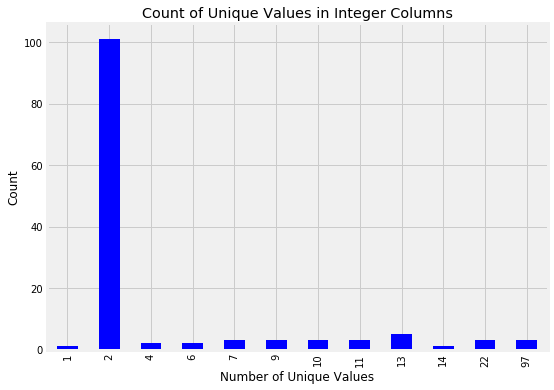

In [ ]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', figsize = (8, 6));
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the `refrig` column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will _not need to aggregate_ these. However, the Boolean columns that are on the individual level will need to be aggregated. 

#### Float Columns

Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an [`OrderedDict`](https://pymotw.com/2/collections/ordereddict.html) to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the `float` columns colored by the value of the `Target`. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

In [ ]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Later on we'll calculate correlations between the variables and the `Target` to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the `meaneduc`, representing the average education of the adults in the household appears to be related to the poverty level: __a higher average adult education leads to higher values of the target which are less severe levels of poverty__. The theme of the importance of education is one we will come back to again and again in this notebook! 

#### Object Columns

The last column type is `object` which we can view as follows.

In [ ]:
train.select_dtypes('object').head()

The `Id` and `idhogar` object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning. According to the documentation for these columns:

* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

These explanations clear up the issue. For these three variables, __"yes" = 1__ and __"no" = 0__. We can correct the variables using a mapping and convert to floats. 

In [ ]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

These variables are now correctly represented as numbers and can be fed into a machine learning model. 

To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the `Target`.

In [ ]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where `parentesco1 == 1` because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

In [ ]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (6, 4), 
                      color = colors.values())

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], list(poverty_mapping.values()))
plt.title('Poverty Level Breakdown');

label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the _macro_ F1 score as the metric instead of _weighted_ F1!). There are many more households that classify as _non vulnerable_ than in any other category. The _extreme_ poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling  (which is covered in more advanced notebooks).

## Addressing Wrong Labels

As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because _individuals in the same household have a different poverty level_. We're not told why this may be the case, but we are told to use the head of household as the true label. 

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason _Why_ the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

### Identify Errors

First we need to find the errors before we can correct them. To find the households with different labels for  family members, we can group the data by the household and then check if there is only one unique value of the `Target`.

In [ ]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

Let's look at one example.

In [ ]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

The organizers tell us that the correct label is that for the head of household, where `parentesco1 == 1`. For this household, the correct label is __3__ for all members. We can correct this (as shown later) by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

### Families without Heads of Household

We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?" 

Well, since you asked, let's investigate exactly that question! 

In [ ]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

In [ ]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

Well that's a relief! This means that we don't have to worry about a household both where there is no head __AND__ the members have different values of the label! For this problem, according to the organizers, __if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training__ Nonetheless, it's still a good exercise to go through this process of investigating the data! 

### Correct Errors

Now we can correct labels for the households that do have a head __AND__ the members have different poverty levels.

In [ ]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

Since we are only going to use the heads of household for the labels, __this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life__. Don't consider it extra work, just practice for your career! 

## Missing Variables

One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

In [ ]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10)

We don't have to worry about the `Target` becuase we made that `NaN` for the test data. However, we do need to address the other 3 columns with a high percentage of missing values.

__v18q1__: Number of tablets

Let's start with `v18q1` which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

#### Function to Plot Value Counts

Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

In [ ]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [ ]:
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a `nan` in this category just do not own a tablet! If we look at the data definitions, we see that `v181` indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can `groupby` the value of `v18q` (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for `v18q1`. This will tell us if the null values represent that the family does not own a tablet.

In [ ]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

Well, that solves the issue! Every family that has `nan` for `v18q1` does not own a tablet. Therefore, we can fill in this missing value with zero.

In [ ]:
data['v18q1'] = data['v18q1'].fillna(0)

__v2a1__: Monthly rent payment

The next missing column is `v2a1` which represents the montly rent payment. 

First we can look at the distribution of this value by the `Target`. This shows only the households that have a measurement of this variable.
sns.violinplot(x = 'Target', y = 'v2a1', data = data, figsize = (10, 6));
It appears there is at least one outlier in this value with a target of 4.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of `tipovivi_`, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes that do not have a monthly rent payment.

In [ ]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (8, 6),
                                                                        color = 'purple');

plt.title('Home Ownership Status for datas Missing Rent Payments', size = 12);

The meaning of the home ownership variables is below:

    tipovivi1, =1 own and fully paid house
    tipovivi2, "=1 own,  paying in installments"
    tipovivi3, =1 rented
    tipovivi4, =1 precarious
    tipovivi5, "=1 other(assigned,  borrowed)"
    
We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information. 

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to 0. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [ ]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

__rez_esc__: years behind in school

The last column with a high percentage of missing values is `rez_esc` indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [ ]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value. 

In [ ]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

The people who are over 17 are presumably out of school and therefore cannot be behind in school. For this value, if the individual is over 17 and they have a missing value, we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [ ]:
# If individual is over 17 and missing years behind, set it to 0
data.loc[(data['age'] > 17) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those 17 and younger with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

data['rez_esc-missing'].value_counts()

The remaining missing values in each column will be filled in, a process known as `Imputation`. We can select the type of imputation to use, and one of the simplest and most effective methods is to fill in the missing values with the `median` of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing. 

In [ ]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

The distribution here seems to match that for all the data at large.

In [ ]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty. 

__This represents an important point__: sometimes the missing information is just as important as the information you are given. 

# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need _all_ of the information summarized for each household. This means grouping the individuals in a house (`groupby`) and performing an aggregation (`agg`) of the individual variables. 

In another notebook, I show how we can use automated feature engineering to do this, and __automated feature engineering__ should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at __automated feature engineering in Featuretools__.

## Column Definitions

Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level. This is where we have to get our hands dirty by digging through the [data decsriptions](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data). There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste (after _checking my work_ of course). 

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

1. Break variables into household level and invididual level
2. Find suitable aggregations for the individual level data
    * Ordinal variables can use statistical aggregations
    * Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data

### Define Variable Categories

There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary. 

In [ ]:
id_ = ['Id', 'idhogar', 'Target']

In [ ]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [ ]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didn't repeat any. 

In [ ]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

#### Squared Variables

First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at `SQBage` vs `age`.

In [ ]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

These variables are highly correlated, and hence I don't think we need both in our data. However, I'll keep a copy of the squared variables so we can experiment with whether or not these help the model.

In [ ]:
squared_data = data[sqr_].copy()

# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

## Id Variables

These are pretty simple: they will be kept as is.

## Household Level Variables

These will mostly be kept as is. 

In [ ]:
heads = data.loc[data['parentesco1'] == 1, :]

In [ ]:
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

### Redundant Household Variables

Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.9 absolute magnitude correlation.

In [ ]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

These are one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [ ]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

There are several variables here having to do with the size of the house:

* r4t3, Total persons in the household
* tamhog, size of the household
* tamviv, number of persons living in the household
* hhsize, household size
* hogar_total, # of total individuals in the household

These variables are all highly correlated with one another. In fact, `hhsize` has a perfect correlation with `tamhog` and `hogar_total`. __We will remove these two variables because the information is redundant.__ We can also remove `r4t3` because it has a near perfect correlation with `hhsize`.

`tamviv` is not necessarily the same as `hhsize` because there might be family members that are not living in the household. We can leave in both of these columns and let's visualize this relationship in a scatterplot.

In [ ]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

In [ ]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: __the difference between these two measurements!__

Let's make this new feature.

In [ ]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_value_counts(heads, 'hhsize-diff')

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at `coopele`

In [ ]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity or get it from a private plant. 

I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions: 

0: No electricity
1: Electricity from cooperative
2: Electricity from CNFL, ICA, ESPH/JASEC
3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own.

In [ ]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [ ]:
plot_value_counts(heads[heads['elec-missing'] == True], 'Target')

The final redundant column is `area2`. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [ ]:
heads = heads.drop(columns = 'area2')
heads.shape

### Mapping Variables

In [ ]:
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)
heads['walls'].describe()

In [ ]:
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads['roof'].describe()

In [ ]:
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
heads['floor'].describe()

In [ ]:
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
heads['walls+roof+floor'].describe()

In [ ]:
heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)

In [ ]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = -1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano']) + -1 * (heads['cielorazo'] == 0)

In [ ]:
sns.violinplot(x = 'warning', y = 'Target', data = heads,
              figsize = (10, 6));

In [ ]:
heads['bonus'] = 1 * (heads['v14a'] + 
                      heads['refrig'] + 
                      heads['computer'] + 
                      heads['cielorazo'] + 
                      heads['television'] + 
                      heads['tipovivi1'])

In [ ]:
sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));

## Exploration of Household Level Variables

After going to all that trouble of figuring out these variables, now we can take a look at these in plots.

# Measuring Correlations

There are many ways for measuring correlations between two variables. Here we will examine two of these:

1. The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables
2. The Spearman Correlation: from -1 to 1 measuring the monotic relationship between two variables

These are best illustrated by example.

In [ ]:
from scipy.stats import spearmanr

In [ ]:
spearmanr([1, 2, 3], [4, 5, 6]).correlation

In [ ]:
def plot_corrs(x, y):
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    p = sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');
    p

In [ ]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

In [ ]:
x = np.array(range(-99, 100))
y = x ** 2

plot_corrs(x, y)

In [ ]:
x = np.array(range(-9, 10))
y = 2 * np.sin(x)

plot_corrs(x, y)

In [ ]:
x = np.array(range(50))
y = 1.01 * x
plot_corrs(x, y)

## Individual Level Variables

There are two types of individual level variables: Boolean (1 or 0 for True or False) and Continuous (can take on any value). 

In [ ]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

## Redundant Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables.

In [ ]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.90)]

to_drop

This is simply the opposite of male! We can remove the male flag.

In [ ]:
ind = ind.drop(columns = 'male')
ind.shape

In [ ]:
ind[[c for c in ind if c.startswith('instl')]].head()

In [ ]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)
ind['inst'].describe()

In [ ]:
sns.violinplot(x = 'Target', y = 'inst', data = ind);

In [ ]:
ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

In [ ]:
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std'])
ind_agg.head()

In [ ]:
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col

In [ ]:
heads = heads.merge(ind_agg, on = 'idhogar', how = 'left')
heads.shape

In [ ]:
corrs = heads.corr()['Target']

In [ ]:
corrs.sort_values().head()

In [ ]:
corrs.sort_values().dropna().tail()

## Handling Variables

* We'll start with the easiest: the __id variables__ should simply be kept in the data because the `idhogar` is how we can group together members of the same household. 
* The __squared variables will be removed__. With a gradient boosting machine, squaring the variables will not provide any benefits and can even hurt the model because the correlation between the squared variable and the original variable is high (these are called [__collinear variables__](https://en.wikipedia.org/wiki/Multicollinearity)). It's possible this transform could be useful for other models, but for now we can remove these columns. 
* The household level features will be left as is.  There is only one household level feature for each household (well hopefully unless the data is off) so we can already use these for training a model

Let's implement these three steps and look at the data we have. __We will build all our features on the `household` dataframe becuase we want to make one row for each household.__ We will join the training data to the testing data to make sure to apply the same transformations. The data can later be separated using whether or not the `Target` `isnull()`. We can then use this table for training and testing a model. The combined training and testing data will be in `data` which we aggregate and eventually join to `household`.



### Average Education vs Poverty by Gender

Let's extract the labels from the dataset so we have them for later training. While we're at it, we can make a boxplot showing the `meaneduc` versus the value of the `Target` colored by the `gender` of the head of household.

In [ ]:
# Extract the labels
label_df = train[train['parentesco1'] == 1].copy()

# Create a gender mapping
label_df['gender'] = label_df['male'].replace({1: 'M', 0: 'F'})

plt.figure(figsize = (8, 6))

# Boxplot
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'gender', data = label_df)
plt.title('Mean Education vs Target by Gender');

We can see the negative relationship between average education and poverty (households with higher average levels of education have less sever poverty) as well as a slight gain in average education if the head of household is a female. Plots can often hide the details, so let's do a numeric summary of the data as well.

In [ ]:
label_df.groupby(['gender', 'Target'])['meaneduc'].agg(['mean', 'count'])

At all poverty levels, the households with female heads have higher levels of average education. I'm not quite sure what to make of this, but it seems right to me! A boxplot does not show the number of observations at each y-value, so for a better visualization that takes into account the number of observations, we can use a violin plot.

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'meaneduc',
               hue = 'gender', data = label_df);

That was a lot of work but we only have to do it once! 

We'll do two quick checks to make sure we didn't add any variables twice and to make sure we included all of the variables in the data.

In [ ]:
len(x) == len(train.columns)

After we define the columns, we need to figure out what to do with all of them. Keep in mind that our approach should probably change as we work with this dataset and I'm open to any suggestions! 



In [ ]:
test['Target'] = np.nan
data = train.append(test)
print('Data shape: ', data.shape)

In [ ]:
household = label_df.copy()
# Add the test data as an append
household = household.append(test[test['parentesco1'] == 1.0], sort = True)
# Remove the squared columns
household = household.drop(columns = sqr_)
# Keep only the household level variables
household = household[id_ + hh_bool + hh_cont + hh_ordered].copy()

household.head()

At this point, the `household` table holds all the household level variables as well as the `Target` and the ids. The individual level data is in `data` which we'll get to in a little bit.

## Correcting Object Type Columns

We still need to deal with the `object` type columns. Three of these are `dependency`, `edjefe`, and `edjefa`. 

Let's visualize the distribution of these variables colored by the `Target`. Below are violin plots of the variables.

In [ ]:
plt.figure(figsize = (24, 6))

# Iterate through the variables
for i, var in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(1, 3, i+ 1)
    # Violinplot colored by `Target`
    sns.violinplot(x = 'Target', y = var, ax = ax,
                   data = household[household['Target'].notnull()], hue = 'Target');
    plt.title(f'{var.capitalize()} by Target');

We can see that a higher `edjefe` and `edjefa` correspond to higher values of the `Target` (lower levels of poverty). It's hard to determine the effect of the dependency on the `Target` from the plot alone.

# Baseline Machine Learning Model

At this point, we can already get started with the machine learning (we'll shortly come back to using the individual level features.) This model can serve _as a baseline_. It's important to establish a baseline model relatively early on in the data science pipeline so you know if the changes you make are having a positive effect on performance. 

For our baseline model, we will use _only the household level data_ and a Random Forest Classifier in Scikit-Learn. This won't get us to the top of the leaderboard, but it will allow us to see how well we can do using only a simple set of features. 

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially _train and test the model 10 times_ using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the `F1 Macro` measure to evaluate performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Labels for training
train_labels = np.array(list(household[household['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
household_train = household[household['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
household_test = household[household['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

Because we are going to be comparing different models, we want to scale the features (limit the range of each column to between 0 and 1). For many ensemble models this is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features. We also impute the missing values with the median of the feature.

For imputing missing values and scaling the features in one step, we can make a pipeline. This will be fit on the training data.

In [ ]:
pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
household_train = pipeline.fit_transform(household_train)
household_test = pipeline.transform(household_test)

Now we can perform 10-fold cross validation on the training data. We'll make a custom scorer so we can use the `macro` F1 score.

In [ ]:
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

model = RandomForestClassifier(random_state=10, 
                               n_estimators=100, n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, household_train, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

That score is not very good, but it's only a baseline! It leaves us plenty of room to improve. After adding the individual level features, we can re-evaluate the model. We'll also use several different models to make sure we are making the correct choice of model! 

# Individual Level Data

The ordinal variables in the individual level data will simply be aggregated. These variables have an inherent ordering, so it makes sense to aggregate them by finding stats such as the `mean`, `min`, and `max`. 

### Ordered Variables

In [ ]:
ind_agg_num = data.groupby('idhogar')[ind_ordered].agg(['mean', 'max', 'min', 'sum'])

new_cols = []
for col in ind_agg_num.columns.levels[0]:
    for stat in ind_agg_num.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

ind_agg_num.columns = new_cols
ind_agg_num.head()

`escolari` is the average schooling so `escolari-mean` is the average schooling of members in the family. This is different than `meaneduc` which is the average education of adults in the household. Let's graph this variable versus the age to see if there is a relationship.

In [ ]:
sns.lmplot('escolari-mean', 'age-mean', data = ind_agg_num, size = 6);
plt.title('Average Age vs Average Education');

It looks like there might be a slightly positive relationship between average age of family members and the average education. Let's look at the distribution of the average years behind.

In [ ]:
ind_agg_num['rez_esc-mean'].round(2).value_counts().sort_index().plot.bar(color = 'red', figsize = (16, 6));
plt.title('Average Years Behind'); plt.xlabel('Years Behind'); plt.ylabel('Count');

This might be better as a kernel density estimate plot, but here we can see the two peaks clearly at 0.0 and 1.0. 
Later, we will look for more trends in the data when we examine correlations between variables and with the `Target`.

### Boolean Variables

The boolean variables won't get the same aggregations: the max of a boolean is just 1 and the min is just 0. Instead, we can take the `sum` of the boolean and the `mean` of the boolean. This will give us both the total number of individuals meeting that criterion in the household and the normalized (divided by the total) total number of individuals.

In [ ]:
train[['v18q', 'v18q1']].head()

In [ ]:
ind_agg_bool = data.groupby('idhogar')[ind_bool].agg(['mean', 'sum'])

new_cols = []
for col in ind_agg_bool.columns.levels[0]:
    for stat in ind_agg_bool.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

ind_agg_bool.columns = new_cols
ind_agg_bool.head()

In [ ]:
plt.figure(figsize = (20, 6))
plt.subplot(131)
ind_agg_bool['male-sum'].value_counts().sort_index().plot.bar(color = 'green')
plt.title('Number of Males Distribution')
plt.subplot(132)
ind_agg_bool['female-sum'].value_counts().sort_index().plot.bar(color = 'orange')
plt.title('Number of Females Distribution');
plt.subplot(133)
sns.kdeplot(ind_agg_bool['female-sum'] / ind_agg_bool['male-sum'])
plt.title('Female:Male Distribution');

The final thing we want to do is simply count the number of individuals in each household. The bar plot shows the distribution (a bar plot is fine in this case because the variable is ordinal and not continuous.

In [ ]:
# Count number of individuals in each household
ind_counts = data.groupby('idhogar')['escolari'].count()

ind_counts.value_counts().sort_index().plot.bar(color = 'red');
plt.title('Count of Individuals by Household');

### Join to the household data

The individual level data can now be merged with the household labeled data on `idhogar` (this will also remove any households that did not have a head of household that we still aggregated). After the merging, we'll have many more features for modeling and for data exploration! 

In [ ]:
print('Original Features: ', household.shape[1])
household = household.merge(ind_agg_num, on = 'idhogar', how = 'left')
print('Features after numeric individual data: ', household.shape[1])
household = household.merge(ind_agg_bool, on = 'idhogar', how = 'left')
print('Features after boolean individual data: ', household.shape[1])
household = household.merge(pd.DataFrame(ind_counts).rename(columns = {'escolari': 'count'}), on = 'idhogar', how = 'left')
print('Features after all individual data: ', household.shape[1])

Later we'll want to try some __feature selection__ to remove unnecessary columns. At the moment however, we'll just take two simple feature selection steps:

1. Remove any one of any pair of columns with a correlation greater than 0.99
2. Remove any columns with only a single unique value

In [ ]:
# Create correlation matrix
corr_matrix = household.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('There are {} columns with >= 0.99 correlation.'.format(len(to_drop)))
to_drop

In [ ]:
household.corr()['count'].sort_values().tail(6).dropna()

Well, it looks like we didn't need to add the counts! 

We're checking for absolute correlations close to 1.0 which means that `female-mean` and `male-mean` are perfectly negatively correlated: by definition, they have to sum to one! 

In [ ]:
sns.lmplot('female-mean', 'male-mean', data = household);
plt.title('Average Female vs Average Male');

This serves as a sanity check that we correctly calculated the statistic!

In [ ]:
print(household['female-mean'].corr(household['male-mean']).round(5))

#Drop the columns
household = household[[x for x in household if x not in to_drop]]

Now for the columns with a single unique value. A column with only one unique value will not be useful for modeling since it contains 0 information.

In [ ]:
household.columns[np.where(household.nunique() == 1)[0]]

`parentesco1-sum` makes a lot of sense because each household will have exactly one head! 

In [ ]:
household = household.drop(columns = ['elimbasu5', 'parentesco1-sum'])

## Evaluate Model with Individual Data

We can now use the expanded set of features enriched with the individual level data to retrain the model and evaluate in cross validation. Hopefully the scores improve.

In [ ]:
# Extract the trianing data
household_train = household[household['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
household_test = household[household['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Extract the features for feature importances
features = list(household_train.columns)
household_train = pipeline.fit_transform(household_train)
household_test = pipeline.transform(household_test) 

# 10 fold cross validation
cv_score = cross_val_score(model, household_train, train_labels, cv = 10, scoring = scorer, verbose = 1)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Including the individual data did improve our cross validation scores! Good thing because we went to a lot of hard work to find those.

## Feature Importances

If we want to view the feature importances, we'll have to train a model on the whole training set. Cross validation does not return the feature importances. Below is a short function we'll use to plot the feature importances. I use this function a lot and often copy and paste it between scripts. I hope the documentation makes sense! 

In [ ]:
def plot_feature_importances(df, n = 15, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df


In [ ]:
model.fit(household_train, train_labels)

# Extract feature importances
fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
norm_fi = plot_feature_importances(fi, 15, threshold=.90)

__Education reigns supreme!__ The most important variable is the average amount of education in the household, followed by the average amount of education of the adults in the household.  I have a suspicion these variables are highly correlated (collinear) which means we may want to remove one of them from the data. The other most important features have to do with the age, the dependency rate, overcrowding, and eventually the number of rooms in the house. Most of these intuitively make sense as being related to the poverty of a household! 

It's interesting that we only need 97 of the ~170 features to account for 90% of the importance. This tells us that we may be able to remove some of the features. However, feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less education leads to more severe poverty) they only tell us which features the model considered relevant. To assess the directionality relationship of features, we can use correlations between the features and the Target.

# Exploring Correlations

While the correlation coefficient only measures _linear relationships_ between two variables, it can still be useful for identifying variables that are related. If we calculate the correlations of variables with the `Target`, this can serve as a first approximation of what varibles will be useful in a machine learning model. 

In [ ]:
corrs = household[household['Target'].notnull()].corr()['Target'].sort_values()
corrs.head()

These are the most _negatively_ correlated variables with the `Target`, meaning that as they increase, the `Target` decreases. Since the lower the target the greater the level of poverty, an increase in these variables means an increase in poverty. Basically, a family with higher levels of these variables is more at risk for extreme poverty. 

For example, a higher total number of `instlevel2` individuals correspond to more poverty. This variable represents that the individual _did not complete primary_ school, showing once again that education is inversely related to poverty. Another actionable insight in the correlations is that more children `hogar_nin` corresponds to greater poverty. Insights such as these are what make data science valuable: if we have the resources, we can act on these findings to improve real-world outcomes.

Next we can look at the most _positive_ correlations with the target. 

In [ ]:
corrs.dropna().tail()

As these variables increase, the poverty tends to decrease. And what do we see on top: education of course! If we had to make one conclusion so far, it's __education is inversely related to poverty.__ We don't know if higher levels of education cause less poverty or if more poverty leads to lower levels of education (it's probably a mix of both) but we do know that these two variables are related. 

The general guidelines for correlation values are below, but these will change depending on who you ask ([source](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) for these):

*  .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
*  .80-1.0 “very strong”

## Plots of Correlations

Let's look at a few of these variables. The following plots are kernel density estimate plots that show the distribution of a single variable. To see how these change with the povery level, the lines will be colored the `Target`.

In [ ]:
plt.figure(figsize = (12, 8))
variable = 'meaneduc'
colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

# Plot each unique level of the target
for level in household[household['Target'].notnull()]['Target'].unique():
    subset = household[(household['Target'].notnull()) & (household['Target'] == level)].copy()
    sns.kdeplot(subset[variable].dropna(), 
                label = f'Poverty Level: {level}', 
                color = colors[subset['Target'].unique()[0]],
                linewidth = 2)
    
plt.xlabel(variable); plt.ylabel('Density');
plt.title('{} Distribution'.format(variable.capitalize()));

`meaneduc` is the average years of education for adults in the household, so this relationship intuitively makes sense: [greater levels of education generally correlate with lower levels of poverty](https://www.childfund.org/poverty-and-education/). We don't necessarily know which causes which, but we do know these tend to move in the same direction.

We might want to use the above code multiple times, so let's put it in a function.

In [ ]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[subset['Target'].unique()[0]])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

We can use this to look at one of the negative correlations.

In [ ]:
kde_target(household[household['Target'].notnull()], 'hogar_nin')

The `hogar_nin` is the number of children 0 - 19 in the family which also makes sense: younger children can be financial source of stress on a family leading to higher levels of poverty. Or, families with lower socioeconomic status have more children in the hopes that one of them will be able to succeed. Whatever the explanation, there is a [real link between family size and poverty](https://www.adb.org/sites/default/files/publication/157217/adbi-rp68.pdf)

A better way to show this plot is as a bar plot because the family size is discrete (an integer).

In [ ]:
household[household['Target'].notnull()].groupby('hogar_nin')['Target'].mean().plot.bar(color = 'blue', figsize = (8, 6));
plt.xlabel('Number of Children'); plt.ylabel('Average Target');
plt.title('Average Poverty Level by Number of Children', size = 16);

A boxplot might also come in handy here.

In [ ]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = 'hogar_nin', y = 'Target', data = household[household['Target'].notnull()]);
plt.title('Target Distribution by Number of Children');

It turns out the boxplot is not a great way to visualize a discrete variable on the y-axis. Let's turn this around and make it into a swarmplot.

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(y = 'hogar_nin', x = 'Target', data = household[household['Target'].notnull()]);
plt.title('Target Distribution by Number of Children');

There is an unmistakeable trend: as family size increases, the target decreases indicating the severity of poverty increases. The jump in average poverty level `Target` at 7 is interesting, and might be caused by a small sample size:

In [ ]:
household[household['Target'].notnull()].groupby('hogar_nin')['Target'].agg(['mean', 'count'])

The seven children family only occurs twice in the data. This illustrates a key point: __be careful about interpreting graphs without looking at the underlying data__. The violinplot may be more accutate in this case because the width of the graph indicates the number of observations occuring at the y-value. Therefore we can see there are relatively few observations of households with a large number of children. It's usually a __good idea to try several plots and also consider the stats themselves when analyzing data.__

The next plot shows the most important variable, the average education of everyone in the household. 

In [ ]:
kde_target(household[household['Target'].notnull()], 'escolari-mean')

#### Correlation Heatmap 

One of my favorite plots is the correlation heatmap because it shows a ton of info in one image. For the heatmap, we'll pick 8 variables and show the correlations between themselves and with the target. 

In [ ]:
variables = ['instlevel2-sum', 'instlevel1-sum', 'hogar_nin', 'meaneduc', 'r4t1', 'age-mean',
             'escolari-max', 'escolari-mean', 'Target']

# Calculate the correlations
corr_mat = household[household['Target'].notnull()][variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (14, 14))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

Feel free to spend as much time taking in the plot as you need! We can immediately notice some trends:

* The `meaneduc` and `escolari-mean` have a high correlation with one another as expected.
* `escolari-mean` and `escolari-max` are also highly correlated as we could have guessed! 
* `escolari-mean` has the most positive correlation of any variable with the `Target`
* `instlevel2-sum` has the most negative correlation of any variable with the target

### Feature Plots

To visualize what the correlation represent, we can use a pairplot which shows scatterplot, kdeplots, and 2D density estimate plots. This uses the `sns.PairGrid` function to show `scatter` plots on the upper triangle, `kdeplot`s on the main diagonal, and 2D kernel density estimate plots on the lower triangle.  


In [ ]:
# Copy the data for plotting
plot_data = household[household['Target'].notnull()][['instlevel2-sum', 'hogar_nin', 'Target', 
                                                        'r4t1', 'escolari-mean']]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

Besides being nice to look at, these plots can be used to inform our modeling decisions or to find insights which might not jump out at us in the quantitative summaries. We already did quite a bit of analysis, so the info in this plot might not be new, but sometimes there is no alternative to getting a look at your data! 

One issue that we can run into when creating variables is highly correlated variables which are called __collinear__. These can slow down model training (in general more features means a slower model to train), decrease model interpretability, and decrease model generalization to the test set. We already removed variables with a perfect correlation (that is they have all the same exact values), but there may still be highly correlated columns we can address later when we do more feature selection.

# Model Selection

Now that we have a good set of features, it's time to get into the modeling. We already tried one basic model, the Random Forest Classifier which delivered a best macro F1 of 0.35. However, in machine learning, there is no way to know ahead of time which model will work best for a given dataset. The following plot shows that __there are some problems where even Gaussian Naive Bayes will outperform a gradient boosting machine__. This is from [an excellent paper by Randal Olson that discusses many points of machine learning](https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf)

![algorithm_comparison](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/algorithm_comparison.png)

What this plot tells us is that we have to try out a number of different models to see which is optimal. Most people eventually settle on the __gradient boosting machine__ and we will try that out, but for now we'll take a look at some of the other options.  There are literally dozens (maybe hundreds) of multi-class machine learning models if we look at the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/multiclass.html). We don't have to try them all, but we should sample from the options.

What we want to do is write a function that can evaluate a model. This will be pretty simple since we already wrote most of the code. In addition to the Random Forest Classifier, we'll try eight other Scikit-Learn models. Luckily, this dataset is relatively small and we can rapidly iterate through the models. We will make a dataframe to hold the results and the function will add a row to the dataframe for each model.

In [ ]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [ ]:
model_results = cv_model(household_train, train_labels, LinearSVC(), 
                         'LSVC', model_results)

That's one model to cross off the list (although we didn't perform hyperparameter tuning so the actual performance could possibly be improved).

In [ ]:
model_results = cv_model(household_train, train_labels, 
                         GaussianNB(), 'GNB', model_results)

That performance is very poor. I don't think we need to revisit the Gaussian Naive Bayes method (although there are problems on which it can outperform the Gradient Boosting Machine).

In [ ]:
model_results = cv_model(household_train, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(16, 32, 64, 64, 32)),
                         'MLP', model_results)

The multi-layer perceptron (a deep neural network) has decent performance. This might be an option if we are able to hyperparameter tune the network. However, the limited amount of data could be an issue with a neural network as these generally require hundreds of thousands of examples to learn effectively.

In [ ]:
model_results = cv_model(household_train, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

__If you run `LinearDiscriminantAnalysis` without filtering out the `UserWarning`s, you get many messages saying "Variables are collinear."__ This might give us a hint that we want to remove some collinear features! We might want to try this model again after removing the collinear variables because the score is comparable to the random forest.

In [ ]:
model_results = cv_model(household_train, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

The linear model (with ridge regularization) does surprisingly well. This might indicate that a simple model can go a long way in this problem (although we'll probably end up using a more powerful method).

In [ ]:
# model_results = cv_model(household_train, train_labels, 
#                          QuadraticDiscriminantAnalysis(), 'QDA', model_results)

In [ ]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(household_train, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)

As one more attempt, we'll consider the ExtraTreesClassifier, a variant on the random forest using ensembles of decision trees as well.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(household_train, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

## Comparing Model Performance

With the modeling results in a dataframe, we can plot them to see which model does the best.

In [ ]:
model_results = cv_model(household_train, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

The most likely candidate seems to be the random forest because it does best right out of the box.  While we didn't tune any of the hyperparameters so the comparison between models is not perfect, these results reflect those of many other Kaggle competitiors finding that tree-based ensemble methods (including the Gradient Boosting Machine) perform very well on structured datasets. Hyperparameter performance does improve the performance of machine learning models, but we don't have time to try all possible combinations of settings for all models. The graph below ([from the paper by Randal Olson](https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf)) shows the effect of hyperparameter tuning versus the default values in Scikit-Learn.

![hyperparameter_improvement](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/hyperparameter_improvement.png)

In most cases the accuracy gain is less than 10% so the worst model is probably not suddenly going to become the best model through tuning. 

For now we'll say the random forest does the best. Later we'll look at using the Gradient Boosting Machine, although not implemented in Scikit-Learn. Instead we'll be using the more powerful [LightGBM version](http://lightgbm.readthedocs.io/en/latest/). Now, let's turn to making a submission using the random forest.

# Making a Submission

In order to make a submission, we need the test data. Fortunately, we have the test data formatted in exactly the same manner as the train data. 

The format of a testing submission is shown below. Although we are making predictions for each household, we actually need one row per individual (identified by the `Id`) but only the prediction for the head of household is scored. 

```
Id,Target
ID_2f6873615,1
ID_1c78846d2,2
ID_e5442cf6a,3
ID_a8db26a79,4
ID_a62966799,4 
```


The `submission_base` will have all the individuals in the test set since we have to have a "prediction" for each individual while the `test_ids` will only contain the `idhogar` from the heads of households. When predicting, we only predict for the heads of households and then we merge the `predictions` dataframe with all of the individuals on the household id (`idhogar`). This will set the `Target` to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored. 

In [ ]:
submission_base = test.loc[:, ['idhogar', 'Id']]
submission_base['idhogar'] = submission_base['idhogar']

# The tests ids are only for the heads of households.
test_ids = list(test.loc[test['parentesco1'] == 1, 'idhogar'])

The function below takes in a model, a training set, the training labels, and a testing set and performs the following operations:

* Trains the model on the training data using `fit`
* Makes predictions on the test data using `predict`
* Creates a `submission` dataframe that can be saved and uploaded to the competition

In [ ]:
def submit(model, train, train_labels, test):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

Let's make a submission with the Random Forest.

In [ ]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         household_train, train_labels, household_test)
rf_submission.to_csv('rf_submission.csv', index = False)

These predictions score __0.370__ when submitted to the competition.

We can visualize the distribution of labels in the test data. This will serve as a sanity check on our predictions.

In [ ]:
rf_submission['Target'].value_counts().sort_index().plot.bar(figsize = (8, 6), 
                                                             color = 'red');
plt.title("Submission Target Value Distribution");

The distribution looks about what we would expect although there appear to be more 4s than in the actual label distribution. We can plot the train label distribution and the predicted label distributed as normed histograms to see if there is a skew.

In [ ]:
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
train['Target'].sort_index().plot.hist(normed = True, ax = axes[0])
plt.xticks([1, 2, 3, 4]);
axes[0].set_title('Train Label Distribution')

rf_submission['Target'].sort_index().plot.hist(normed = True, ax = axes[1])
plt.xticks([1, 2, 3, 4]);

plt.subplots_adjust()
plt.title('Predicted Label Distribution');

It looks like 4 is overrepresented in the predictions and the other labels are underrepresented. To try and fix this, we can specify `class_weight = "balanced"` in the Random Forest which will re-weight the labels by their relative frequency in the data.

In [ ]:
balanced_submission = submit(RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', 
                                              random_state=10, n_jobs = -1), 
                         household_train, train_labels, household_test)
print('Balanced Label Counts')
balanced_submission['Target'].value_counts()

In [ ]:
print('Non balanced label counts')
rf_submission['Target'].value_counts()

Setting class weight to `balanced` _increased_ the number of predicted 4s. This is puzzling and we might want to make a submission with each method and see which does better (although this would technically be tuning with the testing set, which we don't want to do in a real problem). Later, we might look at undersampling the majority class, or [oversampling the minority class](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html) to get better performance. (A few other competitions have tried this tactic with some success).

For now we'll go back to work with the features rather than the model. Notice how this is an iterative procedure: first we do feature engineering and test the model, then we go back and do more feature engineering / feature selection before test the model again. The key point is to measure our performance at each step so we now what improves our model. __Experiment, measure, revise__ is a good workflow!

# Feature Selection

Feature selection is one of the most important topics in machine learning and also an area in which there are no well-estalished standards for removing certain columns. Moreover, there are many different techniques to take. Here, we'll focus on a few simple and straightforward methods:

1. Removing columns with more than 90% missing values 
2. Removing one of every pair of columns with correlation greater than 0.95
3. Removing zero-importance features from a random forest

After these steps, we'll try the modeling again with the Random Forest to see if our cross validation improves.

In [ ]:
missing = pd.DataFrame(household.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = missing['total'] / len(household)
missing.sort_values('percent', ascending = False).head(10)

It turns out that none of the columns have more than 90% missing values.

# Handling Missing Values

Earlier we dealt with missing values by simply filling them in with the median value of the column. However, we should revisit that decision by actually considering what the features represent. 

Let's start with `v18q1` which indicates whether the family owns a tablet. We can look at the value counts of this variable.

In [ ]:
household['v18q1'].value_counts()

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing: in this case, it could be that families with a `nan` in this category just do not own a tablet! I think the safest bet in this case is to set the missing tablet measurements to 0.  We'll do that in the code below and move on to the next column with missing values.

In [ ]:
household['v18q1'] = household['v18q1'].fillna(0)

`v2a1` represents the montly rent payment. For the missing values in this case, it will be interesting to look at the distribution of `tipovivi_`, the columns showing the ownership/renting status of the home. For example, maybe for those households with a missing rent payment, the house is owned which would make sense!

In [ ]:
# Variables indicating home ownership
own_variables = [x for x in household if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
household.loc[household['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (8, 6),
                                                                        color = 'purple');

plt.title('Home Ownership Status for Households Missing Rent Payments', size = 12);

The meaning of the home ownership variables is below:

    tipovivi1, =1 own and fully paid house
    tipovivi2, "=1 own,  paying in installments"
    tipovivi3, =1 rented
    tipovivi4, =1 precarious
    tipovivi5, "=1 other(assigned,  borrowed)"
    
We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information. As a solution, for the houses with no rent payment and the houses are owned, we can set the montly rent payment to 0. For the other houses, we'll leave the missing value to be imputed.

In [ ]:
household.loc[(household['tipovivi1'] == 1), 'v2a1'] = 0

There are many missing values in the columns derived from `rez_esc` indicating years behind in school. For these families, it's possible there are no children and hence no one is any years behind. Let's test this out using the `hogar_nin` and `r4t1` columns and the missing values in the years behind features.

In [ ]:
household.loc[household['rez_esc-mean'].isnull(), ['r4t1', 'hogar_nin']].describe()

It looks like all the missing values in years behind may arise because there are no school-age children in the family. My guess is that this is the case and we will set all the missing values to zero in the years behind-derived columns.

In [ ]:
years_behind = [x for x in household if x.startswith('rez')]
household[years_behind] = household[years_behind].fillna(0)

The final missing values are those in mean education. For these, we can simply replace the missing `meaneduc` with the `escolari-mean`. 

In [ ]:
household.loc[household['meaneduc'].isnull(), 'meaneduc'] = household.loc[household['meaneduc'].isnull(), 'escolari-mean']

household.isnull().sum().sort_values(ascending = False).head()

The only remaining missing values are in the rent column. We will leave these to be filled in via imputation. 

Now we can move on to the highly correlated variables. For each pair of variables with a correlation greater than 0.95, we'll remove one out of the pair.

In [ ]:
# Create correlation matrix
corr_matrix = household.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('There are {} collinear columns to remove.'.format(len(to_drop)))

In [ ]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix.iloc[:20, :20], cmap = plt.cm.RdYlBu_r);

In [ ]:
household_selected = household[[x for x in household if x not in to_drop]].copy()

Finally, we'll use the feature importances from a random forest to remove zero importance variables.

In [ ]:
# Extract the training data
household_train = household_selected[household_selected['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
household_test = household_selected[household_selected['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

feature_names = list(household_train.columns)

# Impute and scale
household_train = pipeline.fit_transform(household_train)
household_test = pipeline.transform(household_test)

# Train a random forest model
model = RandomForestClassifier(1000, random_state = 10)
model.fit(household_train, train_labels)

In [ ]:
np.where(model.feature_importances_ == 0)[0]
feature_names[14]

In [ ]:
household = household.drop(columns = ['pisoother'])

There are no features with 0 importance. Therefore we'll have to leave all the features at this point. Let's re-evaluate performance.

In [ ]:
model = RandomForestClassifier(100, random_state = 10)
model_results = cv_model(household_train, train_labels, model, 'RF-S', model_results)

The feature selection did not improve our model! We'll have to go back to our data before selection.

# Advanced Modeling using the Gradient Boosting Machine

Let's switch back from feature engineering / selection to more advanced modeling using the Gradient Boosting Machine (GBM). This model is extremely popular on Kaggle because of its great performance. The only issue with the GBM is the large number of hyperparameters, which can have a significant effect on model scores. For now, we'll use a set of hyperparameter values I've found work well for other problems (although there's no guarantee these will translate to this problem). Later we can work on hyperparameter tuning. 

In [ ]:
import lightgbm as lgb

To choose the number of estimators (the number of decision trees in the ensemble, called `n_estimators` or `num_boost_rounds`), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [ ]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Light Gradient Boosting Machine Implementation

The function below implements training the gradient boosting machine with Stratified Kfold cross validation and early stopping to prevent overfitting to the training data (although this still does occur). The function performs training with cross validation and records the predictions for each fold. We can then take the mode prediction (breaking ties by whichever label was more common in the training data).

We set the `n_estimators` to 10000 but we won't actually reach this number because we are using early stopping which will quit training estimators when the cross validation metric does not improve for `early_stopping_rounds`. 

In [ ]:
from sklearn.model_selection import StratifiedKFold

def model_gbm(features, labels, test_features, test_ids, nfolds = 5, return_preds = False):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)
    
    # Model with hyperparameters selected from previous work
    model = lgb.LGBMClassifier(boosting_type = 'gbdt', n_estimators = 10000, max_depth = -1,
                               learning_rate = 0.025, metric = 'None', min_child_samples = 30,
                               reg_alpha = 0.35, reg_lambda = 0.6, num_leaves = 15, 
                               colsample_bytree = 0.85, objective = 'multiclass', 
                               class_weight = 'balanced', 
                               n_jobs = -1)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        # Dataframe for 
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        predictions = predictions.append(fold_predictions)
        
        importances += model.feature_importances_ / nfolds    

    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    valid_scores = np.array(valid_scores)
    print(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances
    return submission, feature_importances, valid_scores

Let's look at how this model works by returning the predictions rather than the submission.

In [ ]:
# Extract the training data
household_train = household[household['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
household_test = household[household['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

test_ids = list(household.loc[(household['Target'].isnull()), 'idhogar'])
predictions, feature_importances = model_gbm(household_train, train_labels, household_test, test_ids, return_preds=True)
predictions.head()

The predictions contain the predictions for each fold. This means there might be cases where the predictions do not agree across folds. We can look at the confidence (probability) assigned to each prediction across folds. The kdeplots are colored by the value of the target.

In [ ]:
plt.rcParams['font.size'] = 18
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', size = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();
plt.suptitle('Distribution of Confidence by Fold and Color', y = 1.05);

We see that there are significant differences between folds. There appears to be the highest level of confidence for class 4 predictions which makes sense because this is the majority class. The model trains on many more examples of this class than any other and hence puts more probability on this class. This can potentially be corrected by oversampling the minority classes.

We can look at the same data in a violinplot. This also shows the highest level of confidence for Target 4 with substantial differences between folds.

In [ ]:
plt.figure(figsize = (24, 12))
sns.violinplot(x = 'Target', y = 'confidence', hue = 'fold', data = predictions);

### Average Predictions over Folds

To actually make one final prediction for each household, we want to average the predictions across folds. This means we have essentially built a bagging classifier by combining together predictions across folds. Each classifier trains on a different subset of the data, so this would be an example of bagging: bootstrap aggregating. 

In [ ]:
# Average the predictions over folds
predictions = predictions.groupby('idhogar', as_index = False).mean()

# Find the class and associated probability
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
predictions = predictions.drop(columns = ['fold'])

predictions.head()

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

We see the same story: higher confidence for Target class 4. Overall, the levels of confidence in the predictions are not very high (I'm not sure if this is common for the Gradient Boosting Machine or an artifact of the small data size and imbalanced labels.

In [ ]:
norm_lgb_fi = plot_feature_importances(feature_importances)

Now we can run the same code but return the submission dataframe. This has the predictions for every individual and is ready for uploading directly to the competition.

In [ ]:
submission, feature_importances, valid_scores_5 = model_gbm(household_train, train_labels, household_test, test_ids)
submission.to_csv('lightgbm_baseline_5fold.csv', index = False)

### Cross Validation with Early Stopping Notes

Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. Overall, __early stopping with cross validation__ is the best method to select the number of estimators in the Gradient Boosting Machine and should be our default technique when we desig an implementation.


In [ ]:
_ = plot_feature_importances(feature_importances)

__Education is still the most important feature.__ This is useful information that should be used, for example, to build more schools! 

In [ ]:
no_importance = list(feature_importances.loc[feature_importances["importance"] == 0, 'feature'])
print(f'There are {len(no_importance)} features with 0 importance.')

We'll make the model both with 5 and 10 folds of cross validation to compare the performance.

In [ ]:
submission, feature_importances, valid_scores_10 = model_gbm(household_train, train_labels,
                                                            household_test, test_ids, nfolds = 10)
submission.to_csv('lgb_10fold_submission.csv', index = False)

### Modeling Results with Light GBM

We'll compare all the models in a single chart making sure to also include the standard deviation across folds.

In [ ]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_5Fold", "GBM_10Fold"], 
                                                   'cv_mean': [valid_scores_5.mean(), valid_scores_10.mean()],
                                                   'cv_std':  [valid_scores_5.std(), valid_scores_10.std()]}),
                                    sort = True)

model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

The Gradient Boosting Machine has the highest average cross validation score but also the greatest variation between folds (I used 5 folds initially and 10 with the other models). There is still some performance to be extracted from this model with tuning (probably using random search).

__The 5 Fold predictions score 0.427 when submitted. Different versions of this kernel might score different results, but this was the highest with the GBM.__

The distribution of the labels still is skewed. One potential way we can address this is through oversampling the lower popularity classes.

# Oversampling (in progress)

## More Feature Engineering / Feature Selection (in progress)

We can use the variables already in the data to make new features. We'll take a look at this more later on, but for now let's make a simple feature: the range (`max` - `min`) of the ages of family members. 

In [ ]:
household['age-range'] = household['age-max'] - household['age-min']
kde_target(household[household['Target'].notnull()], 'age-range')

In [ ]:
household['educ-range'] = household['escolari-max'] - household['escolari-min']
kde_target(household[household['Target'].notnull()], 'educ-range')

In [ ]:
household['phones-per-capita'] = household['qmobilephone'] / household['tamviv']
household['tablets-per-capita'] = household['v18q1'] / household['tamviv']
household['rooms-per-capita'] = household['rooms'] / household['tamviv']
household['rent-per-capita'] = household['v2a1'] / household['tamviv']

For additional feature selection, we can remove any features that the Gradient Boosting Machine gave an importance of 0. These are different than those in the random forest (I think because the trees are shorter in the gradient boosting machine and hence there are fewer splits) with many more features having zero importance.

In [ ]:
household = household[[x for x in household if x not in no_importance]]

We'll train one final model with the new set of features. This time we can use 5 folds for cross validation.

In [ ]:
# Extract the training data
household_train = household[household['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
household_test = household[household['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

submission, feature_importances, valid_scores_adv = model_gbm(household_train, train_labels,
                                                              household_test, test_ids, nfolds = 5)
submission.to_csv('lgb_5adv_submission.csv', index = False)

In [ ]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_5ADV"], 
                                                   'cv_mean': [valid_scores_adv.mean()],
                                                   'cv_std':  [valid_scores_adv.std()]}),
                                    sort = True)

model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

The final model has a _slightly_ lower average cross validation score with the 10 fold cross validation recording the overall best average score. However, it also has a greater standard deviation compared to 5 fold cv. It's possible the model is starting to overfit on some of the features. 

In [ ]:
norm_fi = plot_feature_importances(feature_importances)

Some of the new features make it into the most important. However, these were derived from features that _already_ were important meaning we run the risk of overfitting to the training data. There is still some work that can be done with feature engineering! That is likely where the difference will be made in this competition.

In [ ]:
household.to_csv('household.csv')

In [ ]:
household.head()

# Feature Selection

In [ ]:
from boruta_py import Boruta

selector = Boruta()

# Conclusions and Next Steps

In this notebook, we went through a step-by-step data science process on a real-world dataset

1. Understand the problem
2. Exploratory Data Analysis
3. Feature Engineering
    * Aggregate data 
    * Deal with missing values
    * Preliminary feature engineering
4. Model Selection
    * Try many different models to see which one is most promising
    * Hyperparameter tuning may also be included
5. Feature selection 
6. Implementing best models

From here, there are a number of aspects we need to work on:

* Hyperparameter tuning: we did not spend much time optimizing the model! 
* Further feature selection: we probably do not need to retain all of the features to get the same performance
* [Oversampling the minority class](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html) / undersampling the majority class: an advanced techinque that might improve performance
* Difference methods for dimensionality reduction such as Principal Components Analysis or [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)
* Examining and trying to explain _why_ our model makes predictions
* Ensembling multiple models

There are plenty of more opportunities for improvement in this compeition. I hope you'll join me along the way. My next kernel for this competition is available: [Featuretools for Good](https://www.kaggle.com/willkoehrsen/featuretools-for-good). It uses automated feature engineering to approach the problem.

Best,

Will 
